In [3]:
!pip install m3_learning --no-deps
!pip install -r requirements.txt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import time
from torch.optim.lr_scheduler import StepLR

from m3_learning.util.rand_util import rand_tensor
from m3_learning.viz.style import set_style
from m3_learning.nn.random import random_seed
set_style("printing")
random_seed(seed=42)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [5]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

In [6]:
class Multiscale1DFitter(nn.Module):

    def __init__(self, function, x_data, input_channels, num_params, scaler=None,
                 post_processing=None, device='cuda', loops_scaler=None, **kwargs):
        self.input_channels = input_channels
        self.scaler = scaler
        self.function = function
        self.x_data = x_data
        self.post_processing = post_processing
        self.device = device
        self.num_params = num_params
        self.loops_scaler = loops_scaler

        super().__init__()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        # Fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        # Flatten layer
        self.flatten_layer = nn.Flatten()

        # Final embedding block
        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 16),
            nn.SELU(),
            nn.Linear(16, 8),
            nn.SELU(),
            nn.Linear(8, self.num_params),
        )

    def forward(self, x, n=-1):
        x = torch.swapaxes(x, 1, 2)  # Swap axes 1 and 2
        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (n, 256))
        xfc = self.hidden_xfc(xfc)

        x = torch.reshape(x, (n, 2, 128))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)

        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)
        unscaled_param = embedding

        if self.scaler is not None:
            unscaled_param = (embedding * torch.tensor(self.scaler.var_ ** 0.5).to(self.device)
                              + torch.tensor(self.scaler.mean_).to(self.device))
        else:
            unscaled_param = embedding

        fits = self.function(unscaled_param, self.x_data, device=self.device)
        out = fits

        if self.post_processing is not None:
            out = self.post_processing.compute(fits)
        else:
            out = fits

        if self.loops_scaler is not None:
            out_scaled = (out - torch.tensor(self.loops_scaler.mean).to(self.device)) / torch.tensor(self.loops_scaler.std).to(self.device)
        else:
            out_scaled = out

        return out_scaled, unscaled_param

In [7]:
class Polynomial_func:
    def __init__(self, x, range=[-1,1], degree = 3, size=(1,1), batch_size=100, device="cuda"):
        self.x = x
        self.range = range
        self.degree = degree
        self.size = size
        self.batch_size = batch_size
        self.device = device

    def generate(self):
        hold = []
        for n in range(self.degree + 1):
            p = rand_tensor(
                min=self.range[0],
                max=self.range[1],
                size=(self.batch_size, self.size[0], self.size[1]),
            )
            hold.append(p)
        params = torch.stack(hold)
        params = torch.atleast_2d(params)
        params = torch.transpose(params, 0, 1)
        params = torch.transpose(params, 1, 2)
        params = params.to(self.device)

        x = (
            torch.cat(params.shape[0] * [self.x])
            .reshape(params.shape[0], -1)
            .to(self.device)
        )
        x = torch.transpose(x, 0, 1).to(self.device)
        y = torch.zeros_like(x)

        for d in range(self.degree+1):
            coeffs = params[:,0,d,0]
            # print(f"{d} Coeffs Shape: {coeffs.shape}")
            # print(f"{d} Coeffs: {coeffs}")
            y += coeffs*(x**d)
        # print(f"y Shape: {y.shape}")
        # print(f"y: {y}")
        # print(f"x Shape: {x.shape}")
        # print(f"x: {x}")
        out = torch.zeros(
                (params.shape[0], self.x.shape[0],
                self.size[0], self.size[1])
            ).to(self.device)            
        out[:,:,0,0] = torch.transpose(y,0,1)
        return (torch.sum(out,dim=3), out), params




In [46]:
sample_size = 10000
batch_size = 5000
degree = 7
x_values = torch.linspace(-1,1, sample_size)
constructor = Polynomial_func(x=x_values, range=[-1,1], degree=degree, batch_size=sample_size, device=device)
output = constructor.generate()
spectra, params = output
spectra_full, spectras = spectra

dataloader = DataLoader(spectra_full, batch_size=batch_size)

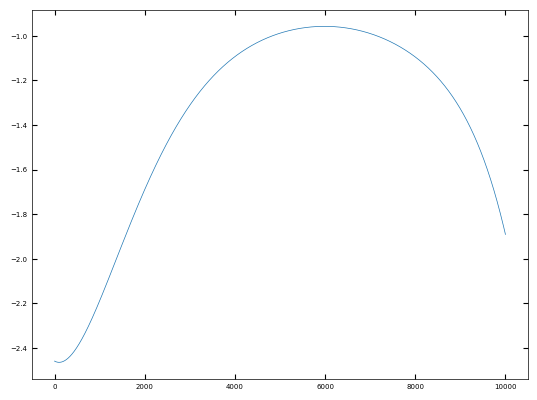

In [47]:
r = np.random.randint(0, 100)
plt.plot(spectra_full[r, :, 0].detach().cpu().numpy())

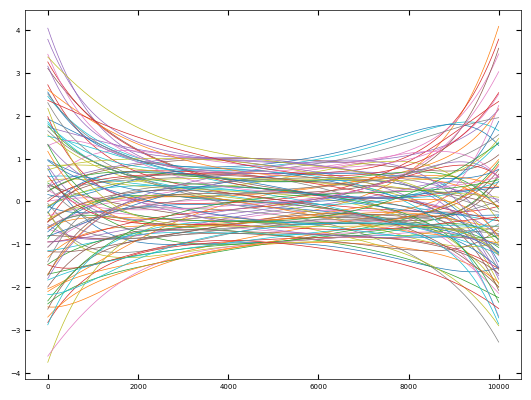

In [48]:
for i in range(100):
    plt.plot(spectra_full[i, :, 0].detach().cpu().numpy(), "-")

In [49]:
def polynomial_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    y = torch.zeros((params.size(0),x.shape[0])).to(device)
    ran = params.size(1)
    if params.ndim > 2:
        ran = params.size(2)
    for c in range(ran):
        if params.ndim > 2:
            coeff = params[:, 0, c, 0].type(torch.float).unsqueeze(1).to(device)
        else:
            coeff = params[:, c].type(torch.float).unsqueeze(1).to(device)
        y += coeff*(x**c)
    return y

In [33]:
def quadratic_function(params, x, device):
    params = params.to(device)
    x = x.to(device)
    a = params[:, 0].type(torch.float).unsqueeze(1).to(device)
    b = params[:, 1].type(torch.float).unsqueeze(1).to(device)
    c = params[:, 2].type(torch.float).unsqueeze(1).to(device)
    print(a.shape)
    return a*x**2 + b*x + c

In [ ]:
xs = torch.linspace(-1, 1, 100).unsqueeze(1)
ps = torch.stack([rand_tensor(-1, 1, (100, 1, 1)) for _ in range(degree + 1)], dim=2)
ys = polynomial_function(ps, torch.tensor(xs), device)
plt.plot(xs, ys.detach().cpu().numpy());

In [60]:
model = Multiscale1DFitter(function=polynomial_function, x_data=x_values, input_channels=1, num_params=degree+1, device=device).to(device)

In [61]:
random_seed(seed=42)
loss_func = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003)
scheduler = StepLR(optimizer, step_size=100, gamma=0.1)

Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [62]:
epochs = 100
for epoch in range(epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    model.train()

    for train_batch in dataloader:
        train_batch = train_batch.to(device)
        pred, _ = model(train_batch)
        loss = loss_func(train_batch.squeeze(2), pred)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]
    train_loss /= total_num
    scheduler.step()

    print("epoch : {}/{}, loss = {:.8f}".format(epoch, epochs, train_loss))
    print("--- %s seconds ---" % (time.time() - start_time))

epoch : 0/100, loss = 0.62291032
--- 0.9127097129821777 seconds ---
epoch : 1/100, loss = 0.30987999
--- 0.8875827789306641 seconds ---
epoch : 2/100, loss = 0.23746955
--- 0.8714685440063477 seconds ---
epoch : 3/100, loss = 0.20456716
--- 0.8787417411804199 seconds ---
epoch : 4/100, loss = 0.16564018
--- 0.8792417049407959 seconds ---
epoch : 5/100, loss = 0.17263325
--- 0.8955183029174805 seconds ---
epoch : 6/100, loss = 0.15528632
--- 0.8931217193603516 seconds ---
epoch : 7/100, loss = 0.14559402
--- 0.8923084735870361 seconds ---
epoch : 8/100, loss = 0.13127805
--- 0.8773453235626221 seconds ---
epoch : 9/100, loss = 0.12858912
--- 1.0615544319152832 seconds ---
epoch : 10/100, loss = 0.11894040
--- 0.8944356441497803 seconds ---
epoch : 11/100, loss = 0.10569659
--- 0.8919949531555176 seconds ---
epoch : 12/100, loss = 0.09376910
--- 0.8807373046875 seconds ---
epoch : 13/100, loss = 0.08764800
--- 0.8800444602966309 seconds ---
epoch : 14/100, loss = 0.07883710
--- 0.8888862

Parameters: tensor([ 0.4146,  0.8980, -0.3252,  0.6073, -0.3008,  0.5371, -0.2923,  0.6662],
       device='cuda:6', grad_fn=<SliceBackward0>)


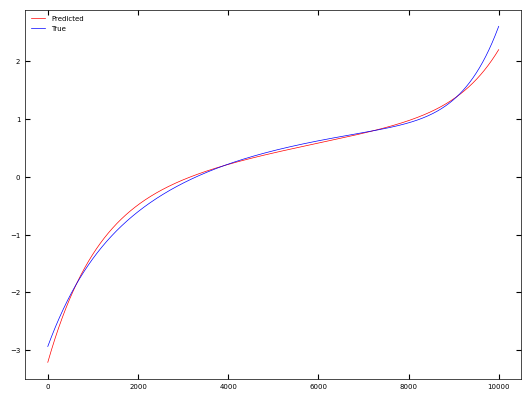

In [84]:
model.eval
spectra_generated, params = model(train_batch)
rand = np.random.randint(0, 100)
print(f"Parameters: {params[rand, :]}")
plt.plot(spectra_generated[rand, :].detach().cpu().numpy(), "r", label='Predicted')
plt.plot(train_batch[rand, :].detach().cpu().numpy(), "b", label='True')
plt.legend()